In [ ]:
from google.colab import drive
drive.mount("/content/gdrive", force_remount=True)
import os
os.chdir("/content/gdrive/My Drive/CS498DL/CS498DL-project/cases")

Mounted at /content/gdrive


In [ ]:
import numpy as np
import torch
import matplotlib.pyplot as plt

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Define neural network

In [ ]:
# Model
import torch
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):

    def __init__(self, nof=50, dim=2, num_layers=4):
        super().__init__()
        self.dim = dim
        self.input_layer = nn.Linear(dim, nof)
        def f():
          return nn.Sequential(nn.Linear(nof, nof), nn.Tanh())
        self.hidden_layer = nn.Sequential(
            *[f() for _ in range(num_layers)],
        )
        self.output_layer = nn.Linear(nof, 1)


    def forward(self, x, y):
        input = torch.cat((x, y), dim=-1)
        input = torch.tanh(self.input_layer(input))
        input = self.hidden_layer(input)
        input = self.output_layer(input)
        return input

# Initialize data and forcing function

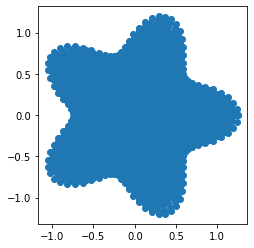

In [ ]:
# Initialize data
gridsize_r = 25
gridsize_t = 100
theta = torch.linspace(0, 2.0 * np.pi, gridsize_t, device=device)
a = 1.0
n = 5
eps = 0.25
r_bc = a + eps * a * torch.cos(n * theta)
r = torch.linspace(0.01, 1, gridsize_r, device=device)
R = torch.outer(r, r_bc)
T = torch.outer(torch.ones_like(r), theta)

# convert to x and y
X = R * torch.cos(T)
Y = R * torch.sin(T)
X = X.to(device)
Y = Y.to(device)

# load f data into torch
X = X.reshape((gridsize_r, gridsize_t, 1))
Y = Y.reshape((gridsize_r, gridsize_t, 1))
Xc = X.clone().to(device)
Xc.requires_grad = True
Yc = Y.clone().to(device)
Yc.requires_grad = True

# # load BC data into torch
bound_r_max = torch.sin(theta)

def plot(*args):
  return map(lambda x : x.cpu().detach().numpy(), args)

plt.scatter(*plot(X, Y))
plt.gca().set_aspect('equal')

# Loss functions for different pdes

In [ ]:
# loss functions
def pde_loss_poisson(pred, x, y, lambda_pde):
    du_dx = torch.autograd.grad(pred.sum(), x, create_graph=True)[0]
    du2_dx2 = torch.autograd.grad(du_dx.sum(), x, create_graph=True)[0]
    du_dy = torch.autograd.grad(pred.sum(), y, create_graph=True)[0]
    du2_dy2 = torch.autograd.grad(du_dy.sum(), y, create_graph=True)[0]
    loss = torch.sum(torch.square(du2_dx2 + du2_dy2))
    return lambda_pde * loss / (gridsize_r * gridsize_t)

def boundary_loss_dirichlet(pred, bound_r_max, lambda_bound=1.0):
    loss = torch.sum((pred[-1, :, 0] - bound_r_max) ** 2)
    return lambda_bound * loss / gridsize_t

# Define analytical solutions for comparison

In [ ]:
# define network
net = Net(nof=50, num_layers=3).to(device)

# define optimizer
learning_rate = 0.005
optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)

Epoch 0 --- Loss : 2.666212797164917, pde_loss : 0.0003312980697955936, bound_loss : 2.665881395339966
Epoch 1000 --- Loss : 0.022347724065184593, pde_loss : 0.0028762766160070896, bound_loss : 0.01947144791483879
Epoch 2000 --- Loss : 0.014757674187421799, pde_loss : 0.008721479214727879, bound_loss : 0.0060361954383552074
Epoch 3000 --- Loss : 0.004896608646959066, pde_loss : 0.0015483718598261476, bound_loss : 0.003348236670717597
Epoch 4000 --- Loss : 0.0034428087528795004, pde_loss : 0.0009889898356050253, bound_loss : 0.002453818917274475
Epoch 5000 --- Loss : 0.004430400673300028, pde_loss : 0.0024254287127405405, bound_loss : 0.0020049719605594873
Epoch 6000 --- Loss : 0.002554670674726367, pde_loss : 0.0011048316955566406, bound_loss : 0.0014498389791697264
Epoch 7000 --- Loss : 0.0032733906991779804, pde_loss : 0.001820809906348586, bound_loss : 0.0014525806764140725
Epoch 8000 --- Loss : 0.002377626020461321, pde_loss : 0.0013157132780179381, bound_loss : 0.00106191262602806

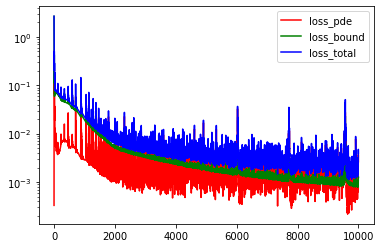

In [ ]:
# train
num_epochs = 10000
lambda_pde = 1.0
lambda_bound = 5.0
log_learning = {"loss_pde" : [],
                "loss_bound" : [],
                "loss_total" : []}
for epoch in range(num_epochs):
    if epoch % 2500 == 0:
        learning_rate *= 0.99

    for param_group in optimizer.param_groups:
        param_group['lr'] = learning_rate

    net.train()

    upred = net.forward(Xc, Yc)

    loss_bound = boundary_loss_dirichlet(upred, bound_r_max, lambda_bound=lambda_bound)
    loss_pde = pde_loss_poisson(upred, Xc, Yc, lambda_pde)
    loss = loss_pde + loss_bound
    log_learning["loss_pde"].append(loss_pde.item())
    log_learning["loss_bound"].append(loss_bound.item())
    log_learning["loss_total"].append(loss.item())

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if epoch % 1000 == 0:
        print(f"Epoch {epoch} --- Loss : {loss}, pde_loss : {loss_pde}, bound_loss : {loss_bound}")

print(loss)
plt.semilogy(log_learning["loss_pde"], 'r', label = 'loss_pde')
plt.semilogy(log_learning["loss_bound"], 'g', label = 'loss_bound')
plt.semilogy(log_learning["loss_total"], 'b', label = 'loss_total')
plt.legend()

In [ ]:
# Saving log file because colab doesnt have plotly shit
import pickle

with open('loss_laplace_arbit.pickle', 'wb') as handle:
    pickle.dump(log_learning, handle)

# Preview results

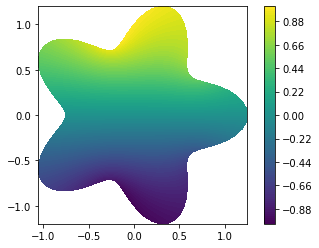

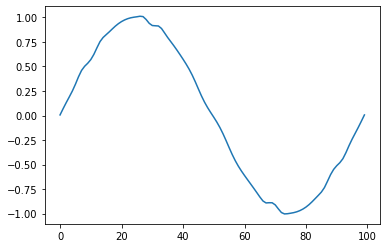

In [ ]:
pinn_sol = net.forward(Xc, Yc)

plt.contourf(*plot(X[:, :, 0], Y[:, :, 0], pinn_sol[:, :, 0]), levels=100,  )
plt.gca().set_aspect('equal')
plt.colorbar()

plt.figure()
plt.plot(*plot(pinn_sol[-1,:,0]))


# Compute numerical solution for comparison

-0.4828674283827462
GMRES iter: 22


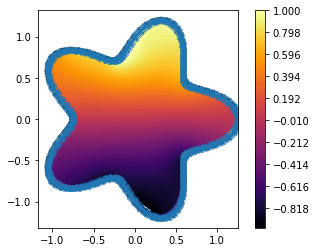

In [ ]:
from arbitdomain_laplace_ie.quad import *
from arbitdomain_laplace_ie.laplace_ie import *

npanels = 100
domain = QuadratureInfo(npanels)
exact_test = u_exact(domain.curve_nodes)
soln1 = bvp(npanels, domain, exact_test)
num_test = eval_DLP(test_targets, domain.curve_nodes, domain.curve_weights, domain.normals, soln1)
ie_sol = num_test.reshape(XD.shape[0], -1)
plt.contourf(XD, YD, ie_sol, levels=np.linspace(-1, 1, 100), cmap="inferno")
plt.colorbar()
plt.show()

# Generate solution and error contours

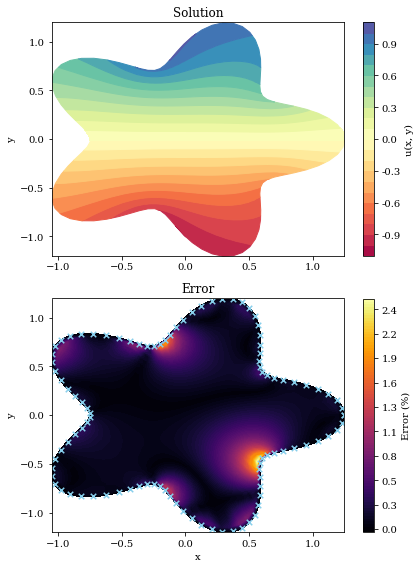

In [ ]:
ana_sol = torch.tensor(ie_sol, device=device).unsqueeze(-1)
pinn_sol = net.forward(Xc, Yc)
error = torch.abs(pinn_sol - ana_sol) / torch.max(torch.abs(ana_sol)) * 100.0
theta = torch.linspace(0, 2.0 * np.pi, gridsize_t, device=device)
error[-1, :, 0] = pinn_sol[-1, :, 0] - torch.sin(theta)

import numpy.linalg as la
err = pinn_sol - ana_sol
err[-1, :, 0] = pinn_sol[-1, :, 0] - torch.sin(theta)
error_l2 = la.norm((err).cpu().detach().numpy()) / np.sqrt(gridsize_r * gridsize_t)

import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Times New Roman'] + plt.rcParams['font.serif']

import matplotlib.ticker as ticker
# specify your own formatter for colorbar labels in return select desired format
def myfmt(x, pos):
    return '{0:.1f}'.format(x)

fig = plt.figure(figsize=(6,8))
ax1 = plt.subplot(211)
cntr1 = ax1.contourf(*plot(X[:, :, 0], Y[:, :, 0], pinn_sol[:, :, 0]), cmap="Spectral", levels=20)
cbar1 = fig.colorbar(cntr1, ax=ax1, label='u(x, y)', format=ticker.FuncFormatter(myfmt))
# ax1.set_xlabel('x')
ax1.set_ylabel('y')
ax1.set_title('Solution')
# This is the fix for the white lines between contour levels
for c in cntr1.collections:
    c.set_edgecolor("face")

ax2 = plt.subplot(212)
cntr2 = ax2.contourf(*plot(X[:,:,0], Y[:,:,0], (error[:,:,0]) + 1e-12), cmap="inferno", levels=100)#np.linspace(0, 6.75, 100))
cbar2 = fig.colorbar(cntr2, ax=ax2, label='Error (%)', format=ticker.FuncFormatter(myfmt))
ax2.scatter(*plot(X[-1, :, 0], Y[-1, :, 0]), s = 30, color='skyblue', marker='x')
ax2.set_xlabel('x')
ax2.set_ylabel('y')
ax2.set_title('Error')
for c in cntr2.collections:
    c.set_edgecolor("face")

plt.tight_layout()


In [ ]:
error_l2

0.03459148303391602

In [ ]:
fig.savefig('laplace_2d_arbit.eps', dpi=300)